In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import

In [2]:
import os
import time
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.metrics import mean_squared_error

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

In [4]:
root_dir = '/root/hoai_workspace/stock-price-prediction/'

In [6]:
!pip install torchviz

DEPRECATION: Python 3.5 reached the end of its life on September 13th, 2020. Please upgrade your Python as Python 3.5 is no longer maintained. pip 21.0 will drop support for Python 3.5 in January 2021. pip 21.0 will remove support for this functionality.


In [8]:
import make_dot

ModuleNotFoundError: No module named 'make_dot'

# Data

### StockChartDataset

In [46]:
class StockChartDataset(object):
    def __init__(self, dir_path, transforms):
        self.dir_path = dir_path
        self.transforms = transforms
        df = pd.read_csv(dir_path + 'target.csv')
        self.imgs = df.filename.tolist()
        self.log_target = df.target.tolist()

    def __getitem__(self, idx):
        # Load images
        img_path = os.path.join(self.dir_path, self.imgs[idx])
        img = Image.open(img_path).convert('RGB')
        
        target = torch.tensor([self.log_target[idx]])

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

### StockChartDataModule

In [47]:
class StockChartDataModule(pl.LightningDataModule):
    def setup(self, stage):
        # transforms for images
        transform=transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        self.train = StockChartDataset(root_dir + 'data/paper_charts/train/',
                                       transforms=transform)
        self.val = StockChartDataset(root_dir + 'data/paper_charts/val/',
                                     transforms=transform)
        self.test = StockChartDataset(root_dir + 'data/paper_charts/test/',
                                      transforms=transform)
        
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=64)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=64)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=64)

# Model

### ResidualBlock

_Ref: https://phamdinhkhanh.github.io/2020/12/19/Resnet.html_

In [48]:
class ResidualBlock(nn.Module):
    def __init__(self, num_channels, output_channels, stride1, stride2, stride3, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.cond = any([stride1 != 1, stride2 != 1, stride3 != 1])
        self.conv1 = nn.Conv2d(num_channels, num_channels, padding=1, 
                            kernel_size=3, stride=stride1)
        self.batch_norm = nn.BatchNorm2d(num_channels)
        self.conv2 = nn.Conv2d(num_channels, num_channels, padding=1, 
                            kernel_size=3, stride=stride2)
        if self.cond:
            self.conv = nn.Conv2d(num_channels, num_channels, padding=0,
                                kernel_size=1, stride=max(stride1, stride2, stride3))
        # Last convolutional layer to reduce output block shape.
        self.conv3 = nn.Conv2d(num_channels, output_channels, padding=0, 
                            kernel_size=1, stride=stride3)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, X):
        if self.cond:
            Y = self.conv(X)
        else:
            Y = X
        X = self.conv1(X)
        X = self.batch_norm(X)
        X = self.relu(X)
        X = self.conv2(X)
        X = self.batch_norm(X)
        X = self.relu(X+Y)
        X = self.conv3(X)
        return X

### StockChartCNN

In [49]:
class StockChartCNN(pl.LightningModule):
    def __init__(self, output_shape=1):
        super(StockChartCNN, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=2, padding=3)
        self.batch_norm = nn.BatchNorm2d(32)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.res_conv1 = ResidualBlock(
            num_channels=32, output_channels=128,
            stride1=1, stride2=1, stride3=1)
        self.res_conv2 = ResidualBlock(
            num_channels=128, output_channels=256,
            stride1=2, stride2=1, stride3=1)
        self.res_conv3 = ResidualBlock(
            num_channels=256, output_channels=512,
            stride1=2, stride2=1, stride3=1)
        self.average_pool = nn.AvgPool2d(kernel_size=7, padding=0)
        self.layer_norm = nn.LayerNorm([512, 1, 1])
        self.fc1 = nn.Linear(in_features=512, out_features=500)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=500, out_features=100)
        self.fc3 = nn.Linear(in_features=100, out_features=25)
        self.out = nn.Linear(in_features=25, out_features=output_shape)
        
    def forward(self, X):
        X = self.conv(X)
        X = self.batch_norm(X)
        X = self.relu(X)
        X = self.max_pool(X)
        X = self.res_conv1(X)
        X = self.res_conv2(X)
        X = self.res_conv3(X)
        X = self.average_pool(X)
        X = self.layer_norm(X)
        X = X.view(X.size(0), -1)
        X = self.fc1(X)
        X = self.dropout(X)
        X = self.fc2(X)
        X = self.dropout(X)
        X = self.fc3(X)
        X = self.dropout(X)
        X = self.out(X)
        return X
    
    def training_step(self, batch, batch_idx):
        # training_step defined the train loop.
        # It is independent of forward
        x, y = batch
        logits = self.forward(x)
        loss = F.mse_loss(logits, y)
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = F.mse_loss(logits, y)
        # Logging to TensorBoard by default
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.01, momentum=0.9)
        return optimizer

# Trainer

In [50]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath='model/',
    filename='cnn-1226-{epoch:02d}-{val_loss:.9f}',
    save_top_k=5,
    mode='min',
)

In [51]:
data_module = StockChartDataModule()

model = StockChartCNN()
# trainer = pl.Trainer(gpus=1, max_epochs=10, callbacks=[checkpoint_callback])

# trainer.fit(model, data_module)

In [55]:
from torchviz import make_dot

ModuleNotFoundError: No module named 'torchviz'

In [23]:
model

StockChartCNN(
  (conv): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (res_conv1): ResidualBlock(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
    (relu): ReLU(inplace=True)
  )
  (res_conv2): ResidualBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv): Conv2d(128, 128, ker

# TensorBoard

In [36]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

# Plot

In [41]:
def plot_price(model, df, path):
    # Get predictions
    transform=transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = StockChartDataset(root_dir + path,
                                transforms=transform)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    predictions = None
    for i, batch in enumerate(dataloader):
        print(i, end='\r')
        X, y = batch
        output = model(X)
        if predictions is None:
            predictions = output.cpu().detach().numpy()
        else:
            predictions = np.row_stack([predictions, output.cpu().detach().numpy()])
    # Get target price
    seq_length = 30
    step_length = 5
    df['target_log'] = np.log(df['Trade Close'].shift(-step_length) / df['Trade Close'])
    length = df.shape[0]
    target_price = df[seq_length+step_length:df.shape[0]]['Trade Close']
    inv = df[seq_length:df.shape[0]-step_length]['Trade Close'].values.reshape(-1, 1)
    predicted_price = inv * (np.exp(1) ** predictions)

    # Visualising the results
    date = np.arange(seq_length+step_length, df.shape[0])
    plt.figure(figsize=(20,10))
    plt.plot(date, target_price, color = 'red', label = 'Target Price')
    plt.plot(date, predicted_price, color = 'blue', label = 'Predicted Price')
    plt.xticks(np.arange(0,len(predicted_price),100))
    plt.title(path[-6:-1].upper() + ' SET: SP500 Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('SP500 Stock Price')
    plt.legend()
    plt.show()
    print(f'RMSE: {mean_squared_error(target_price, predicted_price, squared=False)}')

In [13]:
df = pd.read_csv(root_dir + 'data/sp500_paper_dataset.csv')
print(df.shape)
df.head()

(98310, 7)


,Time,Trade High,Trade Low,Trade Open,Trade Close,Trade Volume,Trade Count
0,0,214.23,214.14,214.15,214.1550,1022241,2274
1,1,214.38,214.14,214.15,214.3699,582984,1902
2,2,214.37,214.18,214.37,214.2800,705964,1943
3,3,214.30,214.16,214.29,214.1900,430066,1321
4,4,214.20,214.09,214.18,214.1000,444761,1599


In [27]:
train_df = df[:68800].copy()
train_df.reset_index(inplace=True)
val_df = df[68800:68800+10000].copy()
val_df.reset_index(inplace=True)
test_df = df[68800+10000:68800+10000+19474].copy()
test_df.reset_index(inplace=True)
train_df.shape, val_df.shape, test_df.shape

((68800, 8), (10000, 8), (19474, 8))

In [31]:
trainer.save_checkpoint(root_dir + 'model/cnn1226_7e_sgd_layer-norm.ckpt')

In [56]:
model = StockChartCNN.load_from_checkpoint(checkpoint_path=root_dir + 'model/cnn1226_7e_sgd_layer-norm.ckpt')

In [57]:
model.to('cpu');

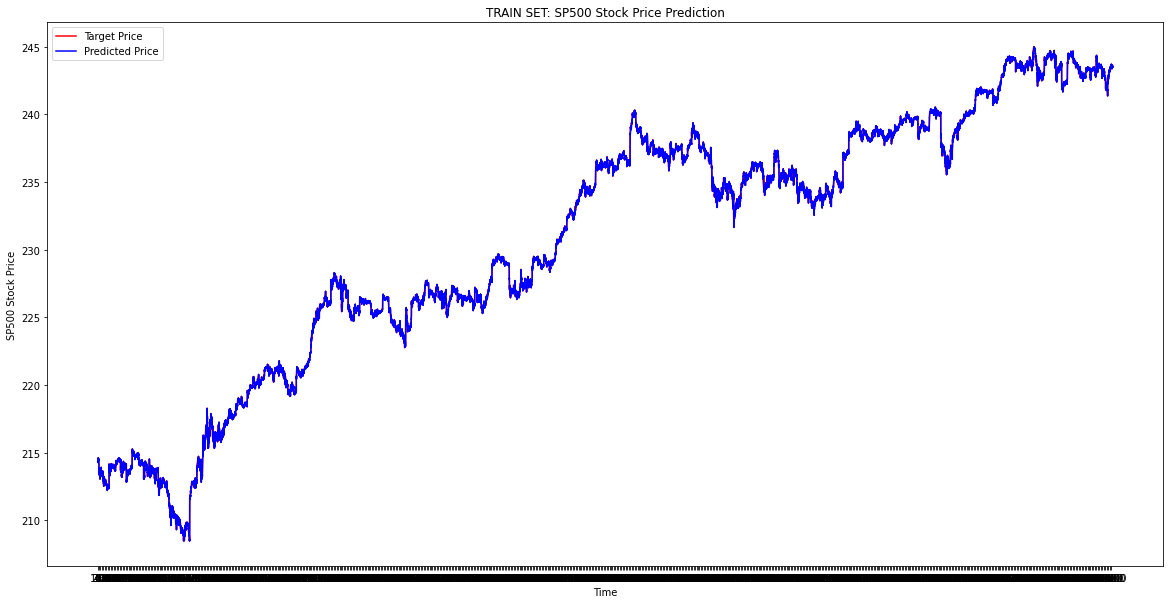

RMSE: 0.12715361596040062


In [28]:
plot_price(model, train_df, 'data/paper_charts/train/')

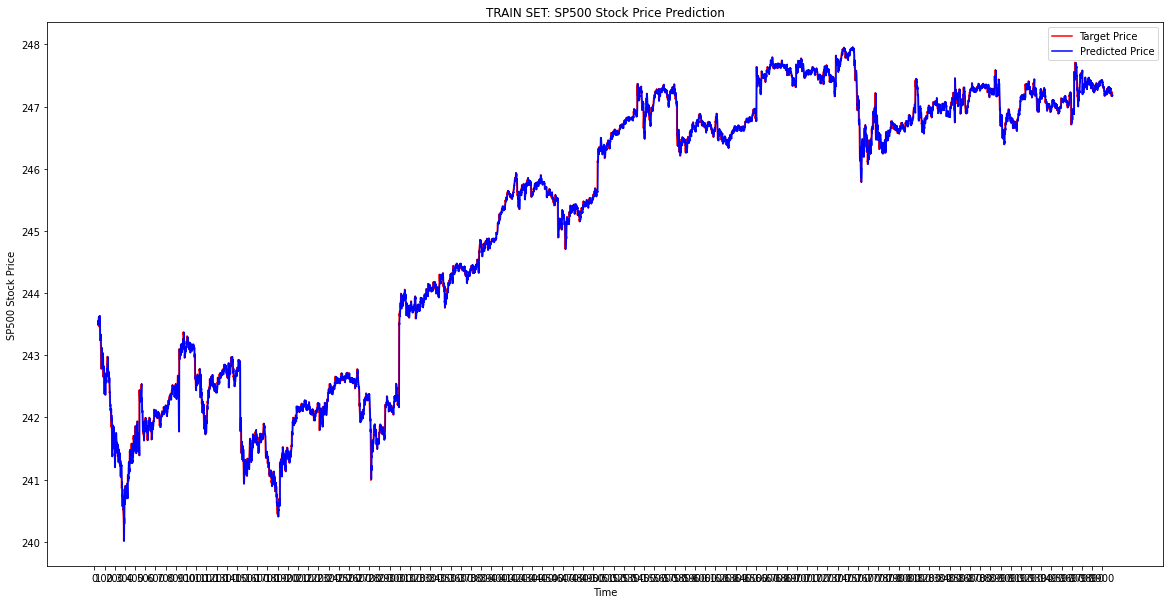

RMSE: 0.10849029392934385


In [35]:
plot_price(model, val_df, 'data/paper_charts/val/')

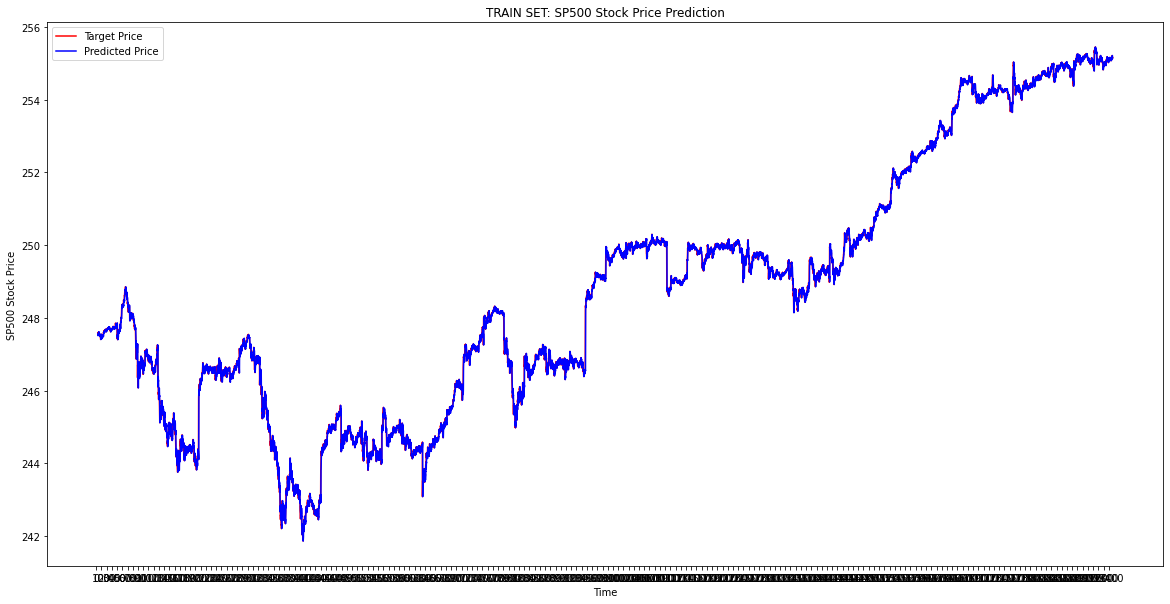

RMSE: 0.11127936549937675


In [34]:
plot_price(model, test_df, 'data/paper_charts/test/')